In [1]:
import pandas as pd
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix,csr_matrix,eye,bmat
from scipy.sparse.linalg import eigs,inv,gmres
from scipy.stats import norm,spearmanr
from scipy.interpolate import UnivariateSpline
from collections import defaultdict
import itertools
import seaborn as sns
import pickle
import multiprocessing
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
data = pd.read_csv('./../data/round.csv')
data = data.loc[data['Permanent_Tournament_#']!=470] ## this is the match play championship, no round scores available

In [3]:
data.head(3)

,Tournament_Year,Permanent_Tournament_#,Course_#,Player_Number,Player_Name,Round_Number,Round_Score,End_of_Event_Pos._(text),Event_Name,Strokes_In_Tournament,Rounds_In_Tournament,Finishing_Position
0,2003,16,656,1320,"Estes, Bob",1,66,T6,Mercedes Championships,271,4,0.208333
1,2003,16,656,1361,"Forsman, Dan",1,69,T21,Mercedes Championships,279,4,0.611111
2,2003,16,656,1761,"Mattiace, Len",1,75,24,Mercedes Championships,280,4,0.666667


In [4]:
data.shape

(257759, 12)

In [5]:
data.tail(3)

,Tournament_Year,Permanent_Tournament_#,Course_#,Player_Number,Player_Name,Round_Number,Round_Score,End_of_Event_Pos._(text),Event_Name,Strokes_In_Tournament,Rounds_In_Tournament,Finishing_Position
259740,2016,60,688,34360,"Reed, Patrick",4,70,T24,TOUR Championship,283,4,0.844828
259741,2016,60,688,37455,"Kim, Si Woo",4,65,T10,TOUR Championship,278,4,0.413793
259742,2016,60,688,40026,"Berger, Daniel",4,68,T15,TOUR Championship,279,4,0.534483


In [6]:
with open('./../PickleFiles/num_to_ind_round.pkl','r') as pickleFile:
    num_to_inds = pickle.load(pickleFile)

In [7]:
data.insert(5,'Player_Index',[num_to_inds[num] for num in data.Player_Number])

_Strokes Gained To The Field_

In [8]:
field_perf = data.groupby(['Tournament_Year','Permanent_Tournament_#','Round_Number','Course_#']).Round_Score.mean().to_dict()

In [9]:
data.insert(len(data.columns),'Field_Performance',[field_perf[tuple(tup)] 
                                                   for tup in data[['Tournament_Year','Permanent_Tournament_#',
                                                                    'Round_Number','Course_#']].values.tolist()])

In [10]:
data.insert(len(data.columns),'Strokes_Gained_To_The_Field',data.Field_Performance-data.Round_Score)

In [11]:
data.Strokes_Gained_To_The_Field.describe()

count    2.577590e+05
mean    -2.877908e-17
std      2.944108e+00
min     -1.965625e+01
25%     -1.830769e+00
50%      1.527778e-01
75%      1.985915e+00
max      1.208571e+01
Name: Strokes_Gained_To_The_Field, dtype: float64

In [12]:
data.sort_values('Strokes_Gained_To_The_Field',ascending=False).head(3)

,Tournament_Year,Permanent_Tournament_#,Course_#,Player_Number,Player_Name,Player_Index,Round_Number,Round_Score,End_of_Event_Pos._(text),Event_Name,Strokes_In_Tournament,Rounds_In_Tournament,Finishing_Position,Field_Performance,Strokes_Gained_To_The_Field
204812,2013,28,789,10809,"Furyk, Jim",21,2,59,3,BMW Championship,271,4,0.042857,71.085714,12.085714
229372,2015,473,8,27141,"Holmes, J.B.",453,1,62,2,World Golf Championships-Cadillac Championship,280,4,0.027397,73.356164,11.356164
13487,2003,56,56,1706,"Love III, Davis",198,1,63,1,The INTERNATIONAL,270,4,0.007194,74.115108,11.115108


In [13]:
tups = data.drop_duplicates(['Tournament_Year','Permanent_Tournament_#'])[['Tournament_Year','Permanent_Tournament_#']].values.tolist()
tournament_groups = {tuple(tup):u/4 for u,tup in enumerate(tups)}

In [14]:
data.insert(len(data.columns),'Tournament_Group',[tournament_groups[tuple(tup)] 
                                                  for tup in data[['Tournament_Year','Permanent_Tournament_#']].values.tolist()])

In [15]:
data.head(3)

,Tournament_Year,Permanent_Tournament_#,Course_#,Player_Number,Player_Name,Player_Index,Round_Number,Round_Score,End_of_Event_Pos._(text),Event_Name,Strokes_In_Tournament,Rounds_In_Tournament,Finishing_Position,Field_Performance,Strokes_Gained_To_The_Field,Tournament_Group
0,2003,16,656,1320,"Estes, Bob",0,1,66,T6,Mercedes Championships,271,4,0.208333,69.361111,3.361111,0
1,2003,16,656,1361,"Forsman, Dan",1,1,69,T21,Mercedes Championships,279,4,0.611111,69.361111,0.361111,0
2,2003,16,656,1761,"Mattiace, Len",2,1,75,24,Mercedes Championships,280,4,0.666667,69.361111,-5.638889,0


In [16]:
player_perfs = data.groupby(['Tournament_Group','Player_Index'],as_index=False).agg({'Round_Number':'count',
                                                       'Strokes_Gained_To_The_Field':'sum'})
player_perfs = {tuple(tup[0:2]):tup[2:] for tup in player_perfs.values.tolist()}

In [17]:
for key in sorted(player_perfs,key=player_perfs.get,reverse=True)[0:10]:
    print key,player_perfs[key]

(24.0, 162.0) [17.0, 47.959821348632985]
(93.0, 711.0) [17.0, 41.779813263631695]
(12.0, 87.0) [17.0, 28.928805245529347]
(59.0, 22.0) [17.0, 28.908535495163534]
(0.0, 10.0) [17.0, 28.13712329337332]
(24.0, 14.0) [17.0, 27.156669400967203]
(0.0, 1.0) [17.0, 18.82462329337332]
(24.0, 183.0) [17.0, 18.156669400967203]
(59.0, 267.0) [17.0, 18.014718290862447]
(93.0, 441.0) [17.0, 15.444530061281924]


In [18]:
len(player_perfs)

41765

In [19]:
def my_norm(x,BETA):
    return norm.pdf(x,0,BETA)/norm.pdf(0,0,BETA)

In [20]:
def take_weighted_ave(a,beta,window_size=35):
    if not a:
        return np.nan
    counts = np.array([count for count,total in a[max(0,len(a)-window_size):]])
    if counts.sum()==0:
        return np.nan
    means = [total/count if count!=0 else 0 for count,total in a[max(0,len(a)-window_size):]]
    x = list(itertools.chain.from_iterable([[means[j]]*int(counts[j]) for j in range(len(counts))]))
    weights = list(itertools.chain.from_iterable([[my_norm(len(counts)-j-1,beta)]*int(counts[j]) 
                                                  for j in range(len(counts))]))
    return np.dot(x,weights)/np.sum(weights)

In [21]:
take_weighted_ave([(7,3.2),(8,7.6),(9,3.4),(10,2.1),(0.0,0),(0,0),(0,0),(1,5.)],1.3)

4.5908045140793075

In [22]:
n_tournament_groups = len(pd.unique(data.Tournament_Group))
players = range(len(num_to_inds))

Training

In [23]:
def run_a_beta(betas):
    pearsons,spearmans = [],[]
    for BETA in betas:
        A = np.array([[take_weighted_ave([player_perfs[(tournament_group,player_ind)] 
                                          if (tournament_group,player_ind) in player_perfs else (0.,0.)
                                          for tournament_group in range(i)],BETA)
                       for i in range(100)]
                      for player_ind in players])

        x,y = [],[]
        for (year,tourn),df in data.groupby(['Tournament_Year','Permanent_Tournament_#'],sort=False):
            if tournament_groups[(year,tourn)]>=100:
                continue
            ratings = A[pd.unique(df.Player_Index),tournament_groups[(year,tourn)]]
            rankings = pd.Series(ratings[~np.isnan(ratings)]).rank(ascending=False,pct=True).values
            finishing_pos = df.groupby('Player_Index').Finishing_Position.mean().to_dict()
            finishing_pos = [finishing_pos[ind] for ind in pd.unique(df.Player_Index)[~np.isnan(ratings)]]
            finishing_pos = pd.Series(finishing_pos).rank(ascending=True,pct=True).values
            x.extend(rankings.tolist())
            y.extend(finishing_pos.tolist())

        pearson,spearman = np.corrcoef(x,y)[0,1],spearmanr(x,y)[0]
        print BETA,pearson,spearman
        pearsons.append(pearson)
        spearmans.append(spearman)
    return (betas,pearsons,spearmans)

In [24]:
def partition (lst, n):
    return [lst[i::n] for i in xrange(n)]

In [25]:
num_cores = multiprocessing.cpu_count()-5
slices = partition(np.linspace(1,27,27),num_cores)
pool = multiprocessing.Pool(num_cores)
results = pool.map(run_a_beta, slices)
pool.close()

26.0 0.200474194902 0.200354577248
24.0 0.200779054409 0.200655598699
22.0 0.201228048313 0.201103278173
27.0 0.200391058899 0.200271963398
20.0 0.201629257593 0.201504398516
23.0 0.201014088225 0.200890197379
17.0 0.202092862039 0.20196749958
16.0 0.202051277623 0.201923304233
25.0 0.200603607655 0.200481328854
19.0 0.201813830854 0.201686071102
15.0 0.202049444653 0.201924052673
21.0 0.201418594154 0.201293817406
12.0 0.201690791059 0.201559830655
13.0 0.202035268025 0.20190865809
10.0 0.20056016422 0.200435030728
18.0 0.202025231851 0.201900680507
6.0 0.194289720757 0.194166546471
4.0 0.187094744161 0.186982321401
11.0 0.201383791683 0.201258406928
7.0 0.196854880312 0.196734852944
1.0 0.162257780022 0.162153712427
8.0 0.198512853911 0.198391817873
5.0 0.191175150272 0.191061396974
9.0 0.199687491691 0.199565112474
3.0 0.181818461225 0.181697570907
14.0 0.202182515771 0.202054011429
2.0 0.17463177483 0.174518244759


In [26]:
results = sum([zip(*results[i]) for i in range(len(results))],[])
results = sorted(results)

In [27]:
max(results,key=lambda x: x[1]),max(results,key=lambda x: x[2])

((14.0, 0.20218251577116772, 0.20205401142919804),
 (14.0, 0.20218251577116772, 0.20205401142919804))

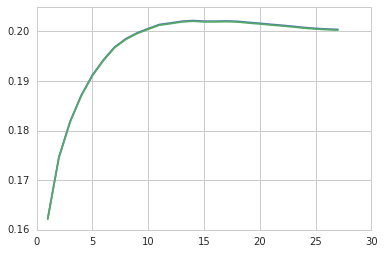

In [28]:
plt.plot([i[0] for i in results],[i[1] for i in results])
plt.plot([i[0] for i in results],[i[2] for i in results]);

Making Test Set

In [ ]:
pearsons,spearmans = [],[]
BETA = 14
A = np.array([[take_weighted_ave([player_perfs[(tournament_group,player_ind)] 
                                  if (tournament_group,player_ind) in player_perfs else (0.,0.)
                                  for tournament_group in range(i)],BETA)
               for i in range(n_tournament_groups)]
              for player_ind in players])

In [24]:
x,y,tourns,years,players = [],[],[],[],[]
for (year,tourn),df in data.groupby(['Tournament_Year','Permanent_Tournament_#'],sort=False):
    if tournament_groups[(year,tourn)]<100:
        continue
    ratings = A[pd.unique(df.Player_Index),tournament_groups[(year,tourn)]-100]
    rankings = pd.Series(ratings[~np.isnan(ratings)]).rank(ascending=False,pct=True).values
    finishing_pos = df.groupby('Player_Index').Finishing_Position.mean().to_dict()
    finishing_pos = [finishing_pos[ind] for ind in pd.unique(df.Player_Index)[~np.isnan(ratings)]]
    finishing_pos = pd.Series(finishing_pos).rank(ascending=True,pct=True).values
    x.extend(rankings.tolist())
    y.extend(finishing_pos.tolist())
    tourns.extend([tourn]*len(rankings))
    years.extend([year]*len(rankings))
    players.extend(pd.unique(df.Player_Index)[~np.isnan(ratings)].tolist())

In [25]:
SGTTF_Test = pd.DataFrame({'x':x,'y':y,'tourn':tourns,'year':years,'player':players})

In [26]:
SGTTF_Test.head(4)

,player,tourn,x,y,year
0,152,32,0.965278,0.881944,2011
1,155,32,0.888889,0.107639,2011
2,0,32,0.500000,0.291667,2011
3,48,32,0.881944,0.621528,2011


In [27]:
len(x),len(y)

(28510, 28510)

In [131]:
year_inds = {value:key[0] for key,value in tournament_groups.iteritems()}
first_group_years = {}
for group in sorted(year_inds):
    if year_inds[group] not in first_group_years:
        first_group_years[year_inds[group]] = group
y_,x_ = zip(*sorted(first_group_years.items()))
f = UnivariateSpline(x_,y_)
year_vals = f(np.arange(n_tournament_groups))
year_vals = map(int,map(__builtins__.round,year_vals))

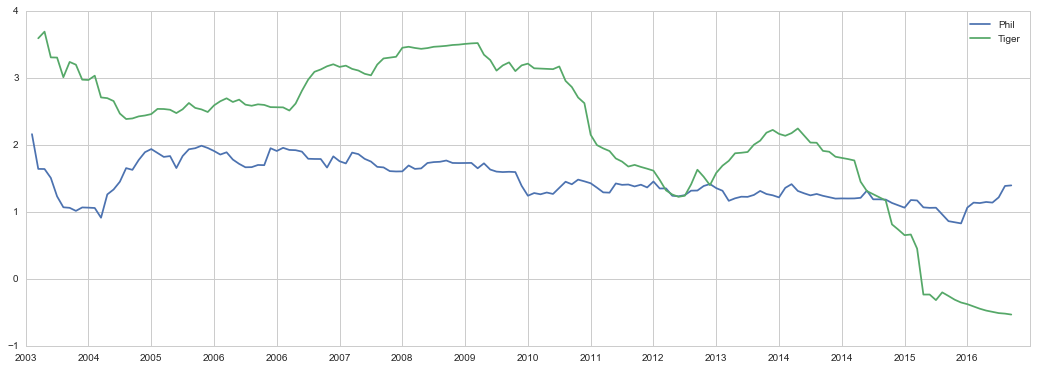

In [133]:
plt.figure(figsize=(18,6))
plt.plot(range(n_tournament_groups),A[162,:],label='Phil')
plt.plot(range(n_tournament_groups),A[277,:],label='Tiger')
plt.xticks(range(n_tournament_groups)[::10],year_vals[::10])
plt.legend();

Park-Newman Ranking Method

In [27]:
def alpha(A,a):
    w = eigs(A,k=1,which='LM',return_eigenvectors=False)
    if w.imag>0:
        print w
    return a/w[0].real

def solve(W,a):
    alpha_ = alpha(W,a)
    w = np.dot(np.linalg.inv(np.eye(W.shape[0])-alpha_*W),W.sum(1))
    
    L = W.T
    alpha_ = alpha(L,a)
    l = np.dot(np.linalg.inv(np.eye(L.shape[0])-alpha_*L),L.sum(1))
               
    ratings = w-l
    ratings[np.logical_and(W.sum(1)==0,L.sum(1)==0)] = np.nan
    return ratings

In [28]:
n_players = len(pd.unique(data.Player_Index))

In [33]:
A = np.zeros((n_players,n_players))
ratings = None
x,y = [],[]
a = .8
for (year,tourn_group),df in data.groupby(['Tournament_Year','Tournament_Group'],sort=False):
    print (year,tourn_group)
    if ratings is not None:
        for tournament,df_ in df.groupby(['Permanent_Tournament_#']):
            current_ratings = ratings[pd.unique(df_.Player_Index)]
            rankings = pd.Series(current_ratings[~np.isnan(current_ratings)]).rank(ascending=False,pct=True)
            finishing_pos = df_.groupby('Player_Index').Finishing_Position.mean().to_dict()
            finishing_pos = [finishing_pos[ind] for ind in pd.unique(df_.Player_Index)[~np.isnan(current_ratings)]]
            finishing_pos = pd.Series(finishing_pos).rank(ascending=True,pct=True).values
            x.extend(rankings.tolist())
            y.extend(finishing_pos.tolist())
    for (course,round),df_ in df.groupby(['Course_#','Round_Number']):
        df_sorted = df_.sort_values('Round_Score')
        for row_ind in range(len(df_)-1):
            A[df_sorted.iloc[row_ind].Player_Index,df_sorted.iloc[row_ind+1:].Player_Index.values] += 1.0
    
    ratings = solve(A,a)

(2003, 0)
(2003, 1)
(2003, 2)
(2003, 3)
(2003, 4)
(2003, 5)
(2003, 6)
(2003, 7)
(2003, 8)
(2003, 9)
(2003, 10)
(2003, 11)
(2004, 11)
(2004, 12)
(2004, 13)
(2004, 14)
(2004, 15)
(2004, 16)
(2004, 17)
(2004, 18)
(2004, 19)
(2004, 20)
(2004, 21)
(2004, 22)
(2004, 23)
(2005, 23)
(2005, 24)
(2005, 25)
(2005, 26)
(2005, 27)
(2005, 28)
(2005, 29)
(2005, 30)
(2005, 31)
(2005, 32)
(2005, 33)
(2005, 34)
(2005, 35)
(2006, 35)
(2006, 36)
(2006, 37)
(2006, 38)
(2006, 39)
(2006, 40)
(2006, 41)
(2006, 42)
(2006, 43)
(2006, 44)
(2006, 45)
(2006, 46)
(2007, 47)
(2007, 48)
(2007, 49)
(2007, 50)
(2007, 51)
(2007, 52)
(2007, 53)
(2007, 54)
(2007, 55)
(2007, 56)
(2007, 57)
(2007, 58)
(2008, 58)
(2008, 59)
(2008, 60)
(2008, 61)
(2008, 62)
(2008, 63)
(2008, 64)
(2008, 65)
(2008, 66)
(2008, 67)
(2008, 68)
(2008, 69)
(2008, 70)
(2009, 70)
(2009, 71)
(2009, 72)
(2009, 73)
(2009, 74)
(2009, 75)
(2009, 76)
(2009, 77)
(2009, 78)
(2009, 79)
(2009, 80)
(2009, 81)
(2010, 81)
(2010, 82)
(2010, 83)
(2010, 84)
(2010, 85

In [34]:
len(x),len(y)

(78669, 78669)

In [35]:
np.corrcoef(x,y)[0,1],spearmanr(x,y)[0]

(0.15684572919612524, 0.15676058380185326)

More Generalized To Take into account Margin of win or loss

In [14]:
def solve(A,G,a):
    alpha_ = alpha(A,a)
    w = np.dot(np.linalg.inv(np.eye(A.shape[0])-alpha_*A),A.sum(1))
    
    g = np.dot(np.linalg.inv(np.eye(G.shape[0])-alpha_*G),G.sum(1))
               
    ratings = w/g
    ratings[g<1] = np.nan
    return ratings

In [43]:
A,G = np.zeros((n_players,n_players)),np.zeros((n_players,n_players))
ratings = None
x,y = [],[]
a = .9
for (year,tourn_group),df in data.groupby(['Tournament_Year','Tournament_Group'],sort=False):
    print (year,tourn_group)
    if ratings is not None:
        for tournament,df_ in df.groupby(['Permanent_Tournament_#']):
            current_ratings = ratings[pd.unique(df_.Player_Index)]
            rankings = pd.Series(current_ratings[~np.isnan(current_ratings)]).rank(ascending=False,pct=True)
            finishing_pos = df_.groupby('Player_Index').Finishing_Position.mean().to_dict()
            finishing_pos = [finishing_pos[ind] for ind in pd.unique(df_.Player_Index)[~np.isnan(current_ratings)]]
            finishing_pos = pd.Series(finishing_pos).rank(ascending=True,pct=True).values
            x.extend(rankings.tolist())
            y.extend(finishing_pos.tolist())
    for (course,round),df_ in df.groupby(['Course_#','Round_Number']):
        A[np.ix_(df_.Player_Index.values,df_.Player_Index.values)] += \
            np.outer(1/df_.Round_Score.values.astype(float),df_.Round_Score.values)
        G[np.ix_(df_.Player_Index.values,df_.Player_Index.values)] += 1.0
    
    ratings = solve(A,G,a)

(2003, 0)
(2003, 1)
(2003, 2)
(2003, 3)
(2003, 4)
(2003, 5)
(2003, 6)
(2003, 7)
(2003, 8)
(2003, 9)
(2003, 10)
(2003, 11)
(2004, 11)
(2004, 12)
(2004, 13)
(2004, 14)
(2004, 15)
(2004, 16)
(2004, 17)
(2004, 18)
(2004, 19)
(2004, 20)
(2004, 21)
(2004, 22)
(2004, 23)
(2005, 23)
(2005, 24)
(2005, 25)
(2005, 26)
(2005, 27)
(2005, 28)
(2005, 29)
(2005, 30)
(2005, 31)
(2005, 32)
(2005, 33)
(2005, 34)
(2005, 35)
(2006, 35)
(2006, 36)
(2006, 37)
(2006, 38)
(2006, 39)
(2006, 40)
(2006, 41)
(2006, 42)
(2006, 43)
(2006, 44)
(2006, 45)
(2006, 46)
(2007, 47)
(2007, 48)
(2007, 49)
(2007, 50)
(2007, 51)
(2007, 52)
(2007, 53)
(2007, 54)
(2007, 55)
(2007, 56)
(2007, 57)
(2007, 58)
(2008, 58)
(2008, 59)
(2008, 60)
(2008, 61)
(2008, 62)
(2008, 63)
(2008, 64)
(2008, 65)
(2008, 66)
(2008, 67)
(2008, 68)
(2008, 69)
(2008, 70)
(2009, 70)
(2009, 71)
(2009, 72)
(2009, 73)
(2009, 74)
(2009, 75)
(2009, 76)
(2009, 77)
(2009, 78)
(2009, 79)
(2009, 80)
(2009, 81)
(2010, 81)
(2010, 82)
(2010, 83)
(2010, 84)
(2010, 85

In [44]:
len(x),len(y)

(78669, 78669)

In [45]:
np.corrcoef(x,y)[0,1],spearmanr(x,y)[0]

(0.17751482307337862, 0.1774347926236042)

Generalized for both time and margin.

Training

In [29]:
def solve(A,G,a,min_g,x_guess=None,x_guess1=None):
    
    alpha_ = alpha(A,a)
    SA = eye(A.shape[0],format='csc')-alpha_*A
    w_a = gmres(SA,A.sum(1),x0=x_guess)[0]
    
    SG = eye(G.shape[0],format='csc')-alpha_*G
    w_g = gmres(SG,G.sum(1),x0=x_guess1)[0]
    
    solve.w_a = w_a
    solve.w_g = w_g
    
    ratings = w_a/w_g
    ratings[w_g<min_g] = np.nan
    return ratings[-n_players:]

In [16]:
def run(a,BETA):
    sys.path.append('./../ProcessingPipeline')
    from makeBigRoundsMat import return_mats
    A,G = return_mats(BETA)
    window_size = 35
    x,y = [],[]
    ratings = None
    for tournament_group in range(100):
        if ratings is not None:
            df = data[data.Tournament_Group==tournament_group]
            for tournament,df_ in df.groupby(['Permanent_Tournament_#']):
                current_ratings = ratings[pd.unique(df_.Player_Index)]
                rankings = pd.Series(current_ratings[~np.isnan(current_ratings)]).rank(ascending=False,pct=True)
                finishing_pos = df_.groupby('Player_Index').Finishing_Position.mean().to_dict()
                finishing_pos = [finishing_pos[ind] for ind in pd.unique(df_.Player_Index)[~np.isnan(current_ratings)]]
                finishing_pos = pd.Series(finishing_pos).rank(ascending=True,pct=True).values
                x.extend(rankings.tolist())
                y.extend(finishing_pos.tolist())

        lower = n_players*max(0,tournament_group-window_size+1)
        upper = n_players*(tournament_group+1)
        if tournament_group==0:
            ratings = solve(A[lower:upper,lower:upper],G[lower:upper,lower:upper],a,1)
        else:
            w_a_approx = np.append(solve.w_a[0 if tournament_group<window_size else n_players:],solve.w_a[-n_players:])
            w_g_approx = np.append(solve.w_g[0 if tournament_group<window_size else n_players:],solve.w_g[-n_players:])
            ratings = solve(A[lower:upper,lower:upper],G[lower:upper,lower:upper],a,1,w_a_approx,w_g_approx)
    print a,BETA,np.corrcoef(x,y)[0,1],spearmanr(x,y)[0]

In [24]:
alphas = np.linspace(.95,.99,3)
betas = np.linspace(11,13,3)

In [26]:
B = pd.DataFrame(np.array([[3,4],[2,1]]))
C = pd.DataFrame(np.array([[3,1],[1,3]]))

In [27]:
B

,0,1
0,3,4
1,2,1


In [28]:
C

,0,1
0,3,1
1,1,3


In [51]:
B.merge(C,on=0)

NameError: name 'B' is not defined

In [ ]:
for a,BETA in itertools.product(alphas[1:],betas):
    run(a,BETA)

0.785 8.0 0.203197998464 0.203058295023
0.785 9.66666666667 0.2042905923 0.204152582767
0.785 11.3333333333 0.204897426307 0.204763277784
0.785 13.0 0.204820873316 0.204687825595
0.83

In [ ]:
for a,BETA in itertools.product(alphas[2:],betas):
    run(a,BETA)

0.83 8.0 0.203451038655 0.203312058317
0.83 9.66666666667 0.204400270856 0.20426189824
0.83 11.3333333333 0.204875956586 0.204738086749
0.83 13.0 0.204955140948 0.204820250975
0.875 8.0 0.203670482167 0.203526648878
0.875 9.66666666667 0.204718890127 0.204579400021
0.875 8.0 0.203832456317 0.203690197574
0.92 9.66666666667 0.204880584933 0.204742524409
Traceback (most recent call last):
  File "/home/ubuntu/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 970, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/ubuntu/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 233, in wrapped
    return f(*args, **kwargs)
  File "/home/ubuntu/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 267, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/home/ubuntu/anaconda2/lib/python2.7/inspect.py", line 1049, in getinnerframes


ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.


Unfortunately, your original traceback can not be constructed.



TypeError: 'NoneType' object is not iterable

In [23]:
for a,BETA in itertools.product(alphas,betas):
    run(a,BETA)

0.92 13.0 0.20495437247 0.204821123628
0.92 14.5 0.204573795437 0.204441221773
0.92 16.0 0.204223325674 0.204091608903
0.935 13.0 0.205038584995 0.204903820282
0.935 14.5 0.204536703009 0.204405211627
0.935 16.0 0.204240437624 0.20410608997
0.95 13.0 0.205045849809 0.204911242335
0.95 14.5 0.20459628345 0.204464405831
Traceback (most recent call last):
  File "/home/ubuntu/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 970, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/ubuntu/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 233, in wrapped
    return f(*args, **kwargs)
  File "/home/ubuntu/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 267, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/home/ubuntu/anaconda2/lib/python2.7/inspect.py", line 1049, in getinnerframes
    framelist.append((tb.tb_frame,)

ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.


Unfortunately, your original traceback can not be constructed.



TypeError: 'NoneType' object is not iterable

In [25]:
for a,BETA in itertools.product(alphas,betas):
    run(a,BETA)

0.95 11.0 0.205036511593 0.204896932851
0.95 12.0 0.205121298005 0.204986099755
0.95 13.0 0.205047778946 0.204913264707
0.97 11.0 0.205064184842 0.204923969999
0.97 12.0 0.205077404728 0.20493814776
0.97 13.0 0.205003288922 0.204868878974
0.99 11.0 0.205090592441 0.204951479066
0.99 12.0 0.205151441954 0.205014093342
0.99 13.0 0.204933559902 0.204800042726


Making Test Set

In [39]:
sys.path.append('./../ProcessingPipeline')
from makeBigRoundsMat import return_mats
a = .99
BETA = 12.0
A,G = return_mats(BETA)
x,y,tourns,years,players = [],[],[],[],[]
window_size = 35
for tournament_group,df in data.groupby('Tournament_Group',sort=False):
    if tournament_group<99:
        continue
    if tournament_group==99:
        lower = n_players*max(0,tournament_group-window_size+1)
        upper = n_players*(tournament_group+1)
        ratings = solve(A[lower:upper,lower:upper],G[lower:upper,lower:upper],a,1)
        continue
    
    for (tournament,year),df_ in df.groupby(['Permanent_Tournament_#','Tournament_Year']):
        current_ratings = ratings[pd.unique(df_.Player_Index)]
        rankings = pd.Series(current_ratings[~np.isnan(current_ratings)]).rank(ascending=False,pct=True).values
        finishing_pos = df_.groupby('Player_Index').Finishing_Position.mean().to_dict()
        finishing_pos = [finishing_pos[ind] for ind in pd.unique(df_.Player_Index)[~np.isnan(current_ratings)]]
        finishing_pos = pd.Series(finishing_pos).rank(ascending=True,pct=True).values
        x.extend(rankings.tolist())
        y.extend(finishing_pos.tolist())
        tourns.extend([tournament]*len(rankings))
        years.extend([year]*len(rankings))
        players.extend(pd.unique(df_.Player_Index)[~np.isnan(current_ratings)].tolist())
    
    lower = n_players*max(0,tournament_group-window_size+1)
    upper = n_players*(tournament_group+1)
    w_a_approx = np.append(solve.w_a[0 if tournament_group<window_size else n_players:],solve.w_a[-n_players:])
    w_g_approx = np.append(solve.w_g[0 if tournament_group<window_size else n_players:],solve.w_g[-n_players:])
    ratings = solve(A[lower:upper,lower:upper],G[lower:upper,lower:upper],a,1,w_a_approx,w_g_approx)

In [40]:
Network_Test = pd.DataFrame({'x':x,'y':y,'tourn':tourns,'year':years,'player':players})

In [41]:
len(Network_Test)

28507

In [42]:
len(SGTTF_Test)

28510

In [43]:
len(SGTTF_Test.merge(Network_Test,on=['tourn','year','player']))

28507

In [79]:
test_data = SGTTF_Test.merge(Network_Test,on=['tourn','year','player'],suffixes=['_sgttf','_network'])

In [80]:
test_data.head()

,player,tourn,x_sgttf,y_sgttf,year,x_network,y_network
0,152,32,0.965278,0.881944,2011,0.958333,0.881944
1,155,32,0.888889,0.107639,2011,0.847222,0.107639
2,0,32,0.500000,0.291667,2011,0.548611,0.291667
3,48,32,0.881944,0.621528,2011,0.923611,0.621528
4,159,32,0.604167,0.236111,2011,0.555556,0.236111


In [81]:
np.corrcoef(test_data.x_sgttf,test_data.y_sgttf)

array([[ 1.        ,  0.19790542],
       [ 0.19790542,  1.        ]])

In [82]:
np.corrcoef(test_data.x_network,test_data.y_network)

array([[ 1.        ,  0.19471992],
       [ 0.19471992,  1.        ]])

In [83]:
np.mean((test_data.x_sgttf-test_data.y_sgttf)**2)**.5

0.365248981689856

In [86]:
np.mean((test_data.x_network-test_data.y_network)**2)**.5

0.3659961752105666

In [116]:
a = test_data.sample(frac=1,replace=True)

In [117]:
np.corrcoef(a.x_sgttf,a.y_sgttf)[0,1],np.corrcoef(a.x_network,a.y_network)[0,1]

(0.19321819378198779, 0.18832690358919904)

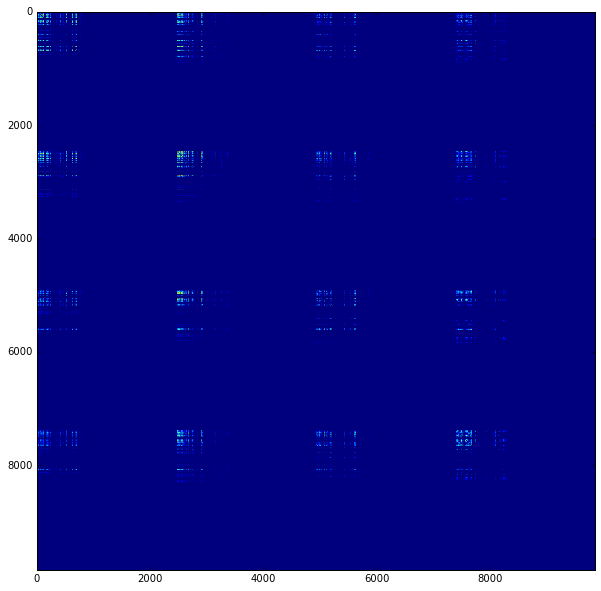

In [47]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(A[10*n_players:14*n_players,10*n_players:14*n_players].toarray());